In [1]:
import numpy as np          # fundamental package for scientific computing
import xarray as xr
import pop_tools
import gsw                  # compute potential density
import os

In [2]:
# Load data from 'events_dens_spg.csv' into a NumPy array.
data = np.genfromtxt('events_dens_spg.csv', delimiter=',', names=True, dtype=None)

# Accessing columns by name
member_numbers = data['Index']
events = data['Values']
member_names = np.zeros(len(member_numbers))

# set periods
before = 1# 40*12
after = 1# 20*12

In [3]:
# find file names 
def find_corresponding_file_name(vvel_number_to_find):
    with open(os.path.expanduser('~/phase1_CONDA/timeseries/order.txt'), 'r') as file:
        vvel_list = file.readlines()
    vvel_dict = {filename.split()[1]: int(filename.split()[0]) for filename in vvel_list}
    vvel_filename = None
    for filename in vvel_list:
        if vvel_dict[filename.split()[1]] == vvel_number_to_find:
            vvel_filename = filename.split()[1]  
            break
    return vvel_filename

# set up regional mask
grid_name = 'POP_gx1v7'
region_defs = {
    'North Atlantic and Nordic Seas': [{'match': {'REGION_MASK': [6, 7, 9]}, 
                             'bounds': {'TLAT': [20., 78.]}}],
    'LabradorSea': [{'match': {'REGION_MASK': [8]}, 'bounds': {'TLAT': [45.0, 66.0]}}]
} 
mask3d = pop_tools.region_mask_3d(grid_name, region_defs=region_defs, mask_name='North Atlantic and Nordic Seas')
mask3d = mask3d.sum('region')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [4]:
# define entire time range for event
member = find_corresponding_file_name(member_numbers[0])[5:]
event = events[0]*12
period_start = event-before
period_end = event+after

# select time range in data arrays
time = slice(period_start, period_end)

temp_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/temp/temp_'+member
ds = xr.open_dataset(temp_file).isel(time=time).where(mask3d == 1).roll(nlon=-100)

salt_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/salt/salt_'+member
ds_salt = xr.open_dataset(salt_file).isel(time=time).where(mask3d == 1).roll(nlon=-100)

hmxl_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/hmxl/hmxl_'+member
ds_hmxl = xr.open_dataset(hmxl_file).isel(time=time).where(mask3d == 1).roll(nlon=-100)

ssh_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/ssh/ssh_'+member
ds_ssh = xr.open_dataset(ssh_file).isel(time=time).where(mask3d == 1).roll(nlon=-100)

shf_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/shf/shf_'+member
ds_shf = xr.open_dataset(shf_file).isel(time=time).where(mask3d == 1).roll(nlon=-100)

ds = ds.update(ds_salt[["SALT"]])

# Compute potential density
CT = gsw.conversions.CT_from_pt(ds.SALT, ds.TEMP)
ds['SIGMA_2'] = gsw.density.sigma2(ds.SALT, CT)

# Correct units and attributes
ds['SIGMA_2'].attrs['units'] = 'kg/m^3 - 1000'
ds['SIGMA_2'].attrs['long_name'] = 'Potential Density at 2000 dbar'

ds = ds.update(ds_hmxl[["HMXL"]])
ds = ds.update(ds_ssh[["SSH"]])
ds = ds.update(ds_shf[["SHF"]])
ds['HMXL'] = ds.HMXL *1e-2
ds['SSH'] = ds.SSH *1e-2
ds['HMXL'].attrs['units'] = 'm'
ds['SSH'].attrs['units'] = 'm'

# Drop weird variables
ds = ds.drop_vars('time_bound')

In [30]:
member

'1301.019.nc'

In [18]:
# save array
ds.to_netcdf('/home/innag3580/phase1_CONDA/results/composites/composite_1301.019')

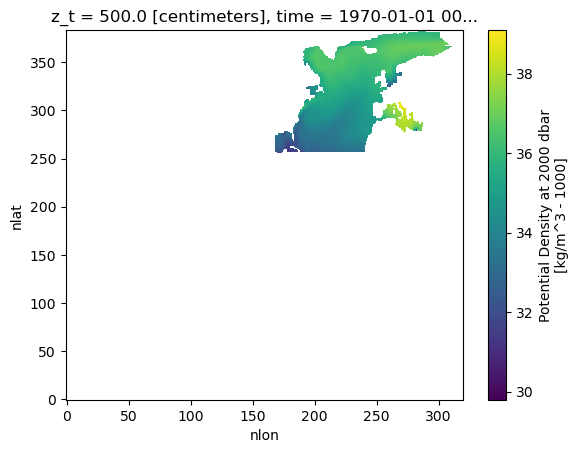

In [22]:
ds.SIGMA_2.isel(time=0, z_t=0).plot()

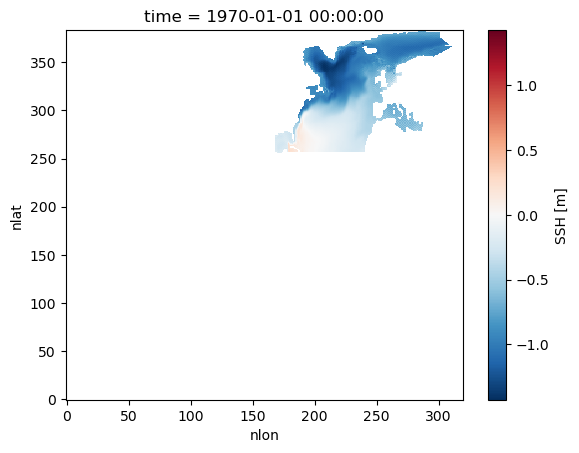

In [28]:
ds.SSH.isel(time=0).plot()